![alt text](Untitled.png)

Analisis de Dataset Gaming Trending 2024 | Informe inicial de analisis

Integrantes:

* Héctor López
* Bárbara Álveal

Docente:    * Giocrisrai Godoy

La industria de los videojuegos no es solo entretenimiento: es un motor cultural que refleja innovación, creatividad y comunidad.
Las “tendencias de gaming” abarcan la evolución de plataformas, géneros, comportamiento de jugadores y economía del sector. Hoy el ecosistema compite entre consolas, PC y mobile; las consolas apuestan por exclusivas, el PC lidera en competitivo/modding y el móvil democratiza el acceso.

El cloud gaming difumina fronteras. Géneros clásicos (Acción, Aventura, RPG) conviven con nichos en auge (Simulación, Supervivencia, indies) y subgéneros (souls-like, roguelike). Las calificaciones y reseñas de usuarios son “moneda” que guía a los desarrolladores hacia modelos live-service y actualizaciones iterativas. Las regiones imprimen estilos distintos (Asia móvil/esports; Norteamérica AAA; Europa indies), y coexisten el músculo de los AAA con la creatividad coste-eficiente de los indies, mientras microtransacciones y pases de temporada sostienen ingresos.
Tecnologías inmersivas (VR/AR/háptica) y el potencial del “metaverso” asoman, y el streaming/esports convierten al juego en espectáculo global. Estas tendencias importan porque moldean comunidades, impulsan innovación y posicionan al gaming a la vanguardia del entretenimiento digital.


# Datos en el Dataset

**Date**:   fecha de lanzamiento del juego.

**Platform**:   plataforma (PC, Consola, Móvil, VR).

**Daily Active Users (DAU)**:   usuarios activos diarios.

**New Registrations**:  nuevos registros.

**Session Duration (min)**:     duración promedio por sesión.

**In-game Purchases ($)**:  ingresos por transacciones dentro del juego.

**Social Media Mentions**:  menciones en redes sociales.

**Stream Viewership**:  audiencia en plataformas de streaming en vivo.

**Revenue ($)**:    ingresos totales (ventas, in-game, suscripciones).

**Top Genre**:  género principal (Acción, RPG, Estrategia, Simulación, etc.).

**Influencer Endorsements**:     0/1 si hubo promoción por influencers.

# Fase 1: analisis del dataset

In [25]:
#Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [26]:
# Carga del dataset (asegúrate de tener el CSV en la misma carpeta que este notebook)
csv_path = "gaming.csv"
assert os.path.exists(csv_path), "No se encontró el archivo Gaming-Trends-2024.csv en el directorio actual."

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columnas:", list(df.columns))
df.head()



Shape: (4989, 11)
Columnas: ['Date', 'Platform', 'Daily Active Users (DAU)', 'New Registrations', 'Session Duration (minutes)', 'In-game Purchases ($)', 'Social Media Mentions', 'Stream Viewership', 'Revenue', 'Top Genre', 'Influencer Endorsements']


,Date,Platform,Daily Active Users (DAU),New Registrations,Session Duration (minutes),In-game Purchases ($),Social Media Mentions,Stream Viewership,Revenue,Top Genre,Influencer Endorsements
0,2022-04-13,PC,142204,14220,31.266635,60772.724060,7116,85079.542766,87378.407590,Action,0
1,2021-03-17,PC,132314,13231,23.314436,43499.834450,6582,64188.420576,41132.113751,Action,0
2,2019-03-09,VR,111557,11155,33.859334,52178.791314,5572,34385.665788,71787.342041,Simulation,0
3,2021-03-31,Console,132909,13290,80.580010,25085.562444,6619,43129.915707,18639.641156,RPG,0
4,2021-02-04,Mobile,130694,13069,37.270903,55277.074439,6555,69341.389827,63849.959750,Action,0


In [27]:
# Tipos y valores faltantes
display(df.dtypes)
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame(name="missing"))

# Duplicados
print("Duplicados:", df.duplicated().sum())

Date                           object
Platform                       object
Daily Active Users (DAU)        int64
New Registrations               int64
Session Duration (minutes)    float64
In-game Purchases ($)         float64
Social Media Mentions           int64
Stream Viewership             float64
Revenue                       float64
Top Genre                      object
Influencer Endorsements         int64
dtype: object

,missing
Date,0
Platform,0
Daily Active Users (DAU),0
New Registrations,0
Session Duration (minutes),0
In-game Purchases ($),0
Social Media Mentions,0
Stream Viewership,0
Revenue,0
Top Genre,0


Duplicados: 0


In [28]:
def find_col(df, key_candidates):
    # Try to find a column in df whose lowercased name contains ALL tokens in any candidate string.
    # Returns the best match or raises ValueError if not found.
    cols = list(df.columns)
    lower = [c.lower() for c in cols]
    scores = []
    for cand in key_candidates:
        tokens = [t.strip() for t in cand.lower().replace("(", " ").replace(")", " ").replace("$"," ").split() if t.strip()]
        for i, lc in enumerate(lower):
            if all(tok in lc for tok in tokens):
                scores.append((i, cols[i], len(tokens)))
                print(f"find_col: candidate '{cand}' matches column '{cols[i]}'")
    if not scores:
        raise ValueError(f"No se encontró ninguna columna para {key_candidates}")
    # prefer the match with more tokens (more specific)
    scores.sort(key=lambda x: (-x[2], x[0]))
    return scores[0][1]

In [29]:
# Normalizamos/parseamos la fecha
try:
    date_col = find_col(df, ["date", "fecha"])
except Exception as e:
    raise

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
assert df[date_col].notna().any(), "La columna de fecha no pudo parsearse. Revisa el formato."

df.describe

find_col: candidate 'date' matches column 'Date'


<bound method NDFrame.describe of            Date Platform  Daily Active Users (DAU)  New Registrations  \
0    2022-04-13       PC                    142204              14220   
1    2021-03-17       PC                    132314              13231   
2    2019-03-09       VR                    111557              11155   
3    2021-03-31  Console                    132909              13290   
4    2021-02-04   Mobile                    130694              13069   
...         ...      ...                       ...                ...   
4984 2020-11-28       VR                    129812              12981   
4985 2020-11-29       VR                    143326              14332   
4986 2020-11-30   Mobile                     37056               3705   
4987 2020-12-01  Console                     65306               6530   
4988 2020-12-02  Console                     68245               6824   

      Session Duration (minutes)  In-game Purchases ($)  \
0                      31.2666


### Estadísticos descriptivos (tendencia central y dispersión)
Incluye: media, mediana, moda, varianza, desviación estándar, rango, coeficiente de variación (CV), IQR, mínimos/máximos, suma y conteos.


In [30]:
def tabla_descriptiva(d): # función para generar tabla descriptiva
    num = d.select_dtypes(include=[np.number]).copy() # seleccionar solo columnas numéricas
    summary = pd.DataFrame(index=num.columns) # crear DataFrame vacío con índices como nombres de columnas numéricas
    # Cálculo de estadísticas
    summary["count"] = num.count()
    summary["sum"] = num.sum()
    summary["mean"] = num.mean()
    summary["median"] = num.median()
    summary["mode"] = num.mode().iloc[0] if not num.mode().empty else np.nan
    summary["var"] = num.var(ddof=1)
    summary["std"] = num.std(ddof=1)
    summary["min"] = num.min()
    summary["q1"] = num.quantile(0.25)
    summary["q3"] = num.quantile(0.75)
    summary["iqr"] = summary["q3"] - summary["q1"]
    summary["max"] = num.max()
    summary["range"] = summary["max"] - summary["min"]
    summary["cv"] = summary["std"] / summary["mean"]
    return summary

desc = tabla_descriptiva(df)
display(desc.round(3))


,count,sum,mean,median,mode,var,std,min,q1,q3,iqr,max,range,cv
Daily Active Users (DAU),4989,5.541345e+08,111071.253,117520.000,10090.000,2.685928e+09,51825.935,10009.000,67896.000,153186.000,85290.000,199907.000,189898.000,0.467
New Registrations,4989,5.541117e+07,11106.669,11752.000,10062.000,2.685925e+07,5182.591,1000.000,6789.000,15318.000,8529.000,19990.000,18990.000,0.467
Session Duration (minutes),4989,2.911048e+05,58.349,56.503,8.236,4.763840e+02,21.826,8.236,40.586,75.941,35.355,99.997,91.761,0.374
In-game Purchases ($),4989,2.598259e+08,52079.755,50127.675,10009.848,6.166147e+08,24831.728,10009.848,31312.561,72301.013,40988.452,99954.557,89944.709,0.477
Social Media Mentions,4989,2.857353e+07,5727.307,5927.000,7502.000,5.933026e+06,2435.780,1001.000,3797.000,7701.000,3904.000,9999.000,8998.000,0.425
Stream Viewership,4989,2.992870e+08,59989.378,59670.765,20012.245,5.238231e+08,22887.182,20012.245,40175.212,79328.228,39153.016,111958.553,91946.308,0.382
Revenue,4989,3.512846e+08,70411.817,64279.960,5010.199,1.763680e+09,41996.192,5010.199,33134.929,106563.118,73428.189,149993.898,144983.699,0.596
Influencer Endorsements,4989,2.243000e+03,0.450,0.000,0.000,3.680000e-01,0.606,0.000,0.000,1.000,1.000,7.000,7.000,1.349


## 3) **Preparación de los Datos (Data Preparation)**
**Objetivos:** imputación de faltantes, tratamiento de outliers, creación de variables y escalamiento.

In [31]:
df_prep = df.copy()

# Imputación simple
for col in df_prep.columns:
    if df_prep[col].dtype.kind in "biufc":
        med = df_prep[col].median()
        df_prep[col] = df_prep[col].fillna(med)
    else:
        mode_val = df_prep[col].mode().iloc[0] if not df_prep[col].mode().empty else "Desconocido"
        df_prep[col] = df_prep[col].fillna(mode_val)

# Clipping por percentiles para estabilizar extremos en numéricas
num_cols = df_prep.select_dtypes(include=[np.number]).columns
lower = df_prep[num_cols].quantile(0.01)
upper = df_prep[num_cols].quantile(0.99)
df_prep[num_cols] = df_prep[num_cols].clip(lower=lower, upper=upper, axis=1)

# Métricas derivadas (si están disponibles)
try:
    dau_col = find_col(df_prep, ["daily active users", "dau"])
    revenue_col = find_col(df_prep, ["revenue", "ingresos"])
    df_prep["ARPU"] = df_prep[revenue_col] / df_prep[dau_col].replace(0, np.nan)
except Exception:
    df_prep["ARPU"] = np.nan

# Variables categóricas A one-hot encoding
cat_cols = df_prep.select_dtypes(include=["object", "category"]).columns.tolist()
# excluir columna de fecha en texto si existiera
try:
    maybe_date = find_col(df_prep, ["date","fecha"])
    cat_cols = [c for c in cat_cols if c != maybe_date]
except Exception:
    pass

df_model = pd.get_dummies(df_prep, columns=cat_cols, drop_first=True)

print("Shape df_model:", df_model.shape)
df_model.head()

find_col: candidate 'daily active users' matches column 'Daily Active Users (DAU)'
find_col: candidate 'dau' matches column 'Daily Active Users (DAU)'
find_col: candidate 'revenue' matches column 'Revenue'
find_col: candidate 'date' matches column 'Date'
Shape df_model: (4989, 17)


,Date,Daily Active Users (DAU),New Registrations,Session Duration (minutes),In-game Purchases ($),Social Media Mentions,Stream Viewership,Revenue,Influencer Endorsements,ARPU,Platform_Mobile,Platform_PC,Platform_VR,Top Genre_Adventure,Top Genre_FPS,Top Genre_RPG,Top Genre_Simulation
0,2022-04-13,142204.0,14220.0,31.266635,60772.724060,7116.0,85079.542766,87378.407590,0,0.614458,False,True,False,False,False,False,False
1,2021-03-17,132314.0,13231.0,23.314436,43499.834450,6582.0,64188.420576,41132.113751,0,0.310867,False,True,False,False,False,False,False
2,2019-03-09,111557.0,11155.0,33.859334,52178.791314,5572.0,34385.665788,71787.342041,0,0.643504,False,False,True,False,False,False,True
3,2021-03-31,132909.0,13290.0,80.580010,25085.562444,6619.0,43129.915707,18639.641156,0,0.140244,False,False,False,False,False,True,False
4,2021-02-04,130694.0,13069.0,37.270903,55277.074439,6555.0,69341.389827,63849.959750,0,0.488545,True,False,False,False,False,False,False


C:\Users\hlope\AppData\Local\Temp\ipykernel_24056\801674627.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M', on='Date')[df.select_dtypes(include=np.number).columns].mean().reset_index()


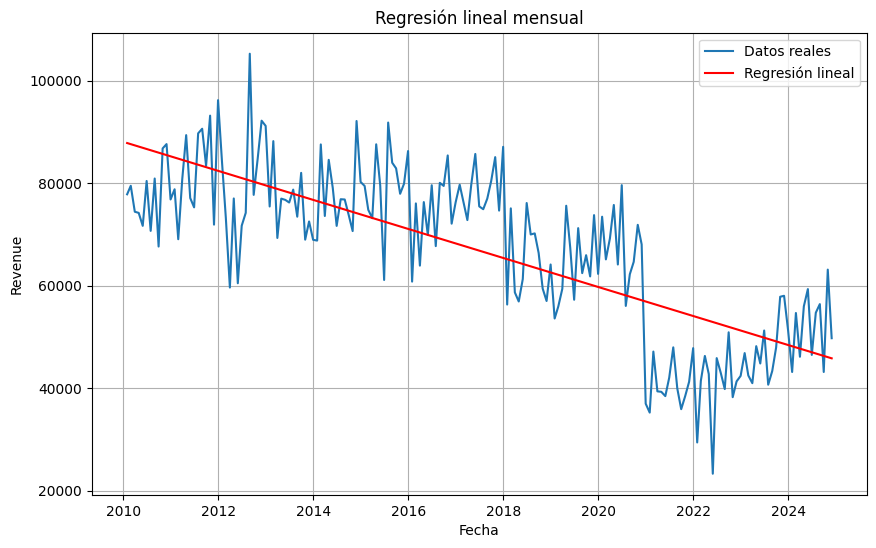

In [32]:
col = 'Revenue'  # columna objetivo

# Asegurar formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

# Agrupar por mes y calcular la media solo en columnas numéricas
df_mensual = df.resample('M', on='Date')[df.select_dtypes(include=np.number).columns].mean().reset_index()

# Crear columna de días desde la primera fecha
df_mensual["dias"] = (df_mensual["Date"] - df_mensual["Date"].min()).dt.days

# Variables
X = df_mensual[["dias"]]
y = df_mensual[col]

# Modelo
modelo = LinearRegression()
modelo.fit(X, y)
df_mensual["prediccion"] = modelo.predict(X)

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(df_mensual["Date"], y, label="Datos reales")
plt.plot(df_mensual["Date"], df_mensual["prediccion"], label="Regresión lineal", color="red")
plt.xlabel("Fecha")
plt.ylabel(col)
plt.title("Regresión lineal mensual")
plt.legend()
plt.grid(True)
#plt.savefig('graficos_generados/regresion_mensual.png')
plt.show()



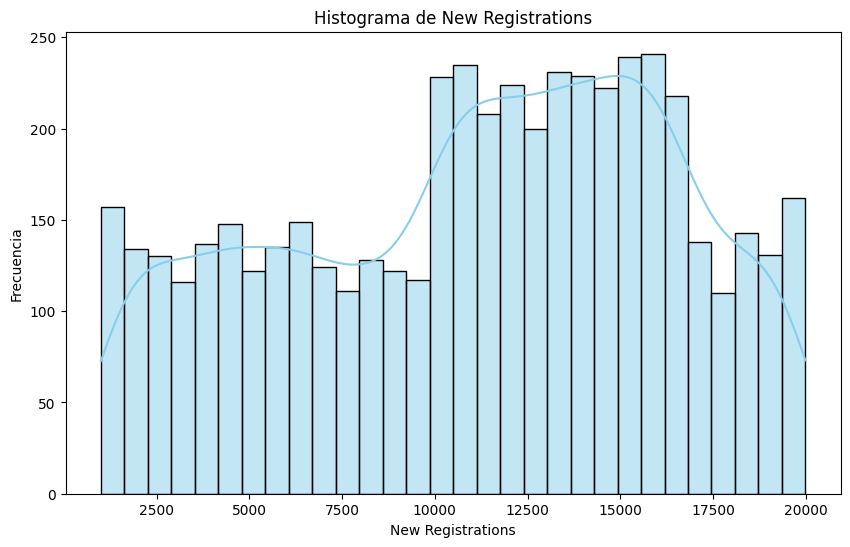

In [33]:
#cambio de columna objetivo
col = 'New Registrations'  # columna objetivo

# Histograma
plt.figure(figsize=(10,6))
sns.histplot(df[col], bins=30, kde=True, color='skyblue') # histograma con línea KDE
plt.title('Histograma de ' + col)
plt.xlabel(col)
plt.ylabel('Frecuencia')
#plt.savefig('graficos_generados/histograma registros.png')
plt.show()

C:\Users\hlope\AppData\Local\Temp\ipykernel_24056\4078560454.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_anual = df.resample('Y', on='Date').agg({col: list})
C:\Users\hlope\AppData\Local\Temp\ipykernel_24056\4078560454.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_anual[col], labels=df_anual.index.year)


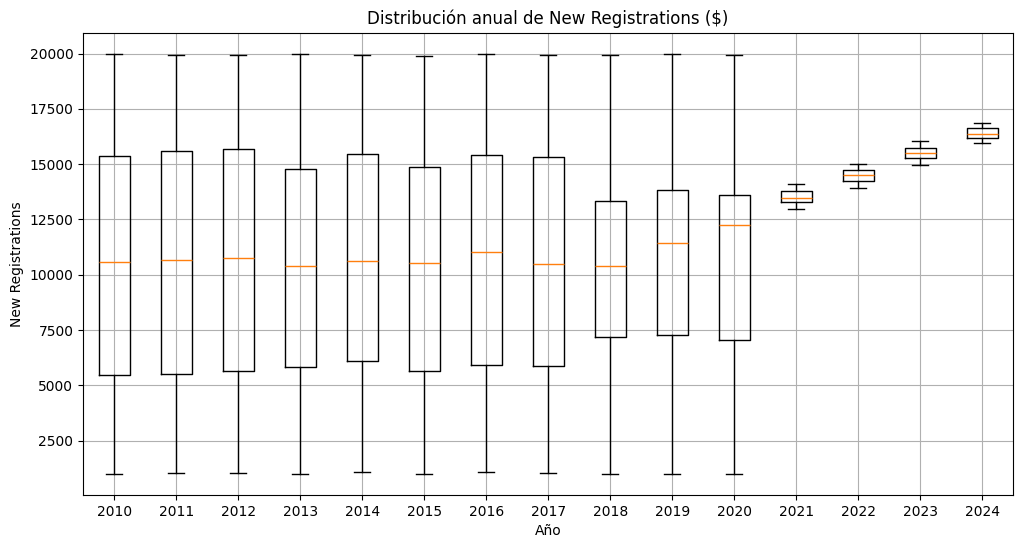

In [34]:
# Agrupar por año
df_anual = df.resample('Y', on='Date').agg({col: list})

# Crear boxplot por año
plt.figure(figsize=(12,6))
plt.boxplot(df_anual[col], labels=df_anual.index.year)
plt.title(f"Distribución anual de {col} ($)")
plt.xlabel("Año")
plt.ylabel(col)
plt.grid(True)
#plt.savefig('graficos_generados/boxplot_anual.png')
plt.show()


## LIMPIEZA


In [35]:
df_cleaned = df.drop_duplicates()

df_cleaned = df_cleaned.dropna()

df_cleaned.shape, df_cleaned.isna().sum().sum(), df_cleaned.duplicated().sum()

((4989, 11), np.int64(0), np.int64(0))

In [36]:
# Asegurar que la columna existe y no tiene valores nulos
df['Top Genre'] = df['Top Genre'].fillna('Desconocido')

# Extraer géneros únicos
generos_unicos = df['Top Genre'].unique()

# Mostrar ordenados
print(" Géneros únicos encontrados:")
for genero in sorted(generos_unicos):
    print("-", genero)


 Géneros únicos encontrados:
- Action
- Adventure
- FPS
- RPG
- Simulation


In [37]:
csv_path = "gaming.csv"
assert os.path.exists(csv_path), "No se encontró el archivo Gaming-Trends-2024.csv en el directorio actual."

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columnas:", list(df.columns))
df.head()

genre_mapping = {
    'Action': '00',
    'Simulation': '01',
    'RPG': '02',
    'FPS': '03',
    'Adventure': '04'
}

df['Top Genre'] = df['Top Genre'].replace(genre_mapping)

df.head()

Shape: (4989, 11)
Columnas: ['Date', 'Platform', 'Daily Active Users (DAU)', 'New Registrations', 'Session Duration (minutes)', 'In-game Purchases ($)', 'Social Media Mentions', 'Stream Viewership', 'Revenue', 'Top Genre', 'Influencer Endorsements']


,Date,Platform,Daily Active Users (DAU),New Registrations,Session Duration (minutes),In-game Purchases ($),Social Media Mentions,Stream Viewership,Revenue,Top Genre,Influencer Endorsements
0,2022-04-13,PC,142204,14220,31.266635,60772.724060,7116,85079.542766,87378.407590,00,0
1,2021-03-17,PC,132314,13231,23.314436,43499.834450,6582,64188.420576,41132.113751,00,0
2,2019-03-09,VR,111557,11155,33.859334,52178.791314,5572,34385.665788,71787.342041,01,0
3,2021-03-31,Console,132909,13290,80.580010,25085.562444,6619,43129.915707,18639.641156,02,0
4,2021-02-04,Mobile,130694,13069,37.270903,55277.074439,6555,69341.389827,63849.959750,00,0


In [38]:
#Date a tipo datetime
#Extraer componentes: año, mes, día, día de la semana, trimestre.

df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Weekday"] = df["Date"].dt.day_name()


In [39]:
#Normalización y escalado

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["DAU", "Revenue ($)", "In-game Purchases ($)"]] = scaler.fit_transform(df[["DAU", "Revenue ($)", "In-game Purchases ($)"]])


KeyError: "['DAU', 'Revenue ($)'] not in index"

In [ ]:
#Ratio de compras por usuario
df["Purchases_per_user"] = df["In-game Purchases ($)"] / df["DAU"]

#Ratio de compras por usuario:
df["Purchases_per_user"] = df["In-game Purchases ($)"] / df["DAU"]

#Engagement estimado: duración × usuarios activos
df["Engagement"] = df["Session Duration (minutes)"] * df["DAU"]

#Influencia social: menciones + endorsements
df["Social_Impact"] = df["Social Media Mentions"] + df["Influencer Endorsements"]


